## From Pearsons correlation

- some negative linear correlation with wind speed and wind gusts
- no cloud cover correlation
- but 'terrestrial_radiation_instant (W/m²)' had a -0.3 coefficient, and so could be an input variable to explore
- it describes the increase in sunlight, which during the summer months has an impact

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from load_dfs import load_openmeteo,load_spotprices,load_consumption

In [2]:
AarhusWeatherdf=load_openmeteo()
DK1spot=load_spotprices()
Consumption=load_consumption()

/Users/jonassinjan/Documents/spotprice_weather_2024/load_dfs.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DK1spotPricesdf.drop('PriceArea', axis=1, inplace=True)
/Users/jonassinjan/Documents/spotprice_weather_2024/load_dfs.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Zonalconsumptiondf.drop('ConnectedArea', axis=1, inplace=True)
/Users/jonassinjan/Documents/spotprice_weather_2024/load_dfs.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [3]:
#need to merge as one df, to run df.corr()
mergeddf = pd.merge(AarhusWeatherdf,DK1spot,left_on='time',right_on='HourDK')
mergeddf = pd.merge(mergeddf,Consumption,left_on='time',right_on='HourDK')
mergeddf['hour_of_day'] = mergeddf['time'].dt.hour

In [6]:
mergeddf.columns.tolist()

['time',
 'temperature_2m (°C)',
 'relative_humidity_2m (%)',
 'dew_point_2m (°C)',
 'apparent_temperature (°C)',
 'precipitation (mm)',
 'rain (mm)',
 'snowfall (cm)',
 'snow_depth (m)',
 'weather_code (wmo code)',
 'pressure_msl (hPa)',
 'surface_pressure (hPa)',
 'cloud_cover (%)',
 'cloud_cover_low (%)',
 'cloud_cover_mid (%)',
 'cloud_cover_high (%)',
 'wind_speed_10m (km/h)',
 'wind_speed_100m (km/h)',
 'wind_direction_10m (°)',
 'wind_direction_100m (°)',
 'wind_gusts_10m (km/h)',
 'boundary_layer_height (m)',
 'wet_bulb_temperature_2m (°C)',
 'total_column_integrated_water_vapour (kg/m²)',
 'is_day ()',
 'sunshine_duration (s)',
 'shortwave_radiation (W/m²)',
 'direct_radiation (W/m²)',
 'diffuse_radiation (W/m²)',
 'direct_normal_irradiance (W/m²)',
 'global_tilted_irradiance (W/m²)',
 'terrestrial_radiation (W/m²)',
 'shortwave_radiation_instant (W/m²)',
 'direct_radiation_instant (W/m²)',
 'diffuse_radiation_instant (W/m²)',
 'direct_normal_irradiance_instant (W/m²)',
 'glob

# Linear Regression Model

- use wind_speed_10m, wind_gusts, terrestrial_radiation
- later add in boundary_layer_height
- later add in ShareMWh

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
# Select the input variables and the target variable
X = mergeddf[['wind_speed_10m (km/h)', 'wind_gusts_10m (km/h)', 'terrestrial_radiation (W/m²)']]
y = mergeddf['SpotPriceEUR']

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")

Mean Squared Error: 1421.301377564944
R^2 Score: 0.30605126418709727
Model Coefficients:
wind_speed_10m (km/h): -3.1692005747448495
wind_gusts_10m (km/h): 0.22117022649718363
terrestrial_radiation (W/m²): -0.04310081362146465


In [16]:
# Calculate baseline MSE (predicting the mean of the target variable)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mse = mean_squared_error(y_test, baseline_pred)
print(f"Baseline Mean Squared Error: {baseline_mse}")

# Compare model MSE with baseline MSE
improvement = (baseline_mse - mse) / baseline_mse * 100
print(f"Improvement over baseline: {improvement:.2f}%")

Baseline Mean Squared Error: 2048.701172312775
Improvement over baseline: 30.62%


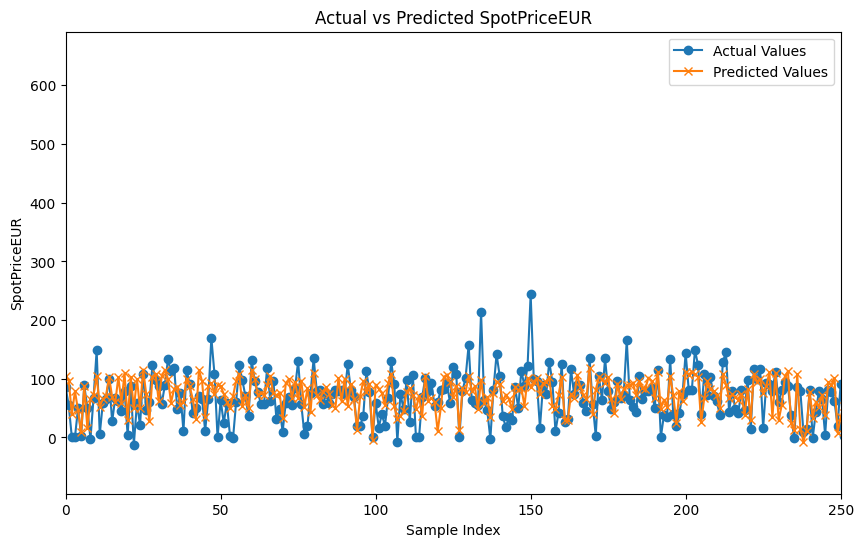

In [18]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Values', marker='o')
plt.plot(y_pred, label='Predicted Values', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('SpotPriceEUR')
plt.title('Actual vs Predicted SpotPriceEUR')
plt.xlim(0,250)
plt.legend()
plt.show()

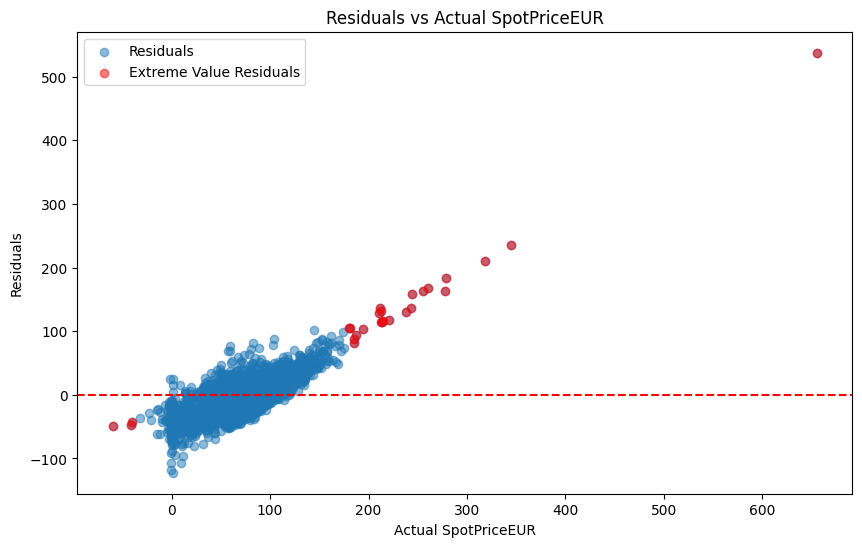

Extreme Values Mean Squared Error: 28154.884208410647
Non-Extreme Values Mean Squared Error: 1019.7570947215075


In [ ]:
# Identify extreme values in the test set (e.g., values beyond 1.5 times the interquartile range)
q1 = y_test.quantile(0.25)
q3 = y_test.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Calculate residuals
residuals = y_test - y_pred

extreme_values = y_test[(y_test < lower_bound) | (y_test > upper_bound)]
extreme_indices = extreme_values.index
extreme_residuals = residuals.loc[extreme_indices]

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, label='Residuals',alpha=0.5)
plt.scatter(extreme_values, extreme_residuals, color='red', label='Extreme Value Residuals',alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual SpotPriceEUR')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual SpotPriceEUR')
plt.legend()
plt.show()

# Calculate MSE for extreme values and non-extreme values
extreme_y_pred = y_pred[np.isin(X_test.index, extreme_indices)]
extreme_mse = mean_squared_error(extreme_values, extreme_y_pred)

non_extreme_values = y_test.drop(extreme_values.index)
non_extreme_pred = y_pred[np.isin(y_test.index, non_extreme_values.index)]
non_extreme_mse = mean_squared_error(non_extreme_values, non_extreme_pred)

print(f"Extreme Values Mean Squared Error: {extreme_mse}")
print(f"Non-Extreme Values Mean Squared Error: {non_extreme_mse}")

In [28]:
residuals.shape

(1757,)

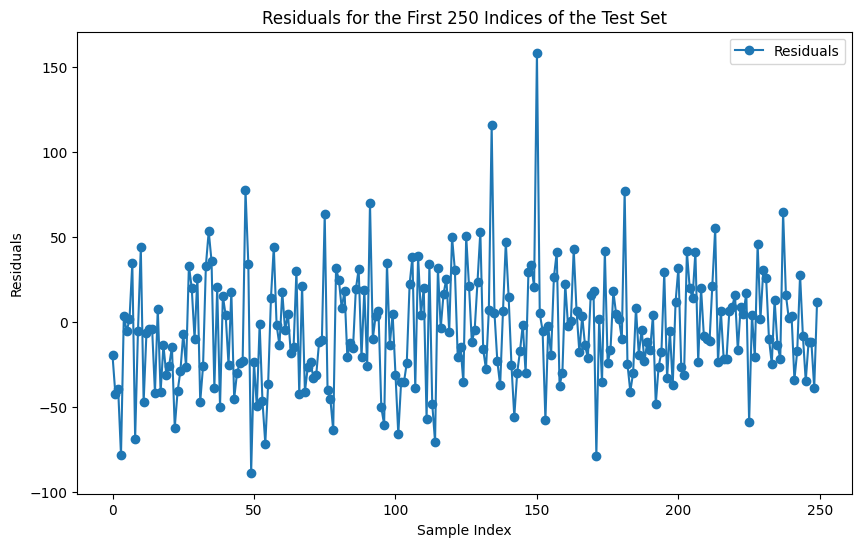

In [29]:
# Plot the residuals for the first 250 indices of the test set
plt.figure(figsize=(10, 6))
plt.plot(range(250),residuals[:250], label='Residuals', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')
plt.title('Residuals for the First 250 Indices of the Test Set')
plt.legend()
plt.show()

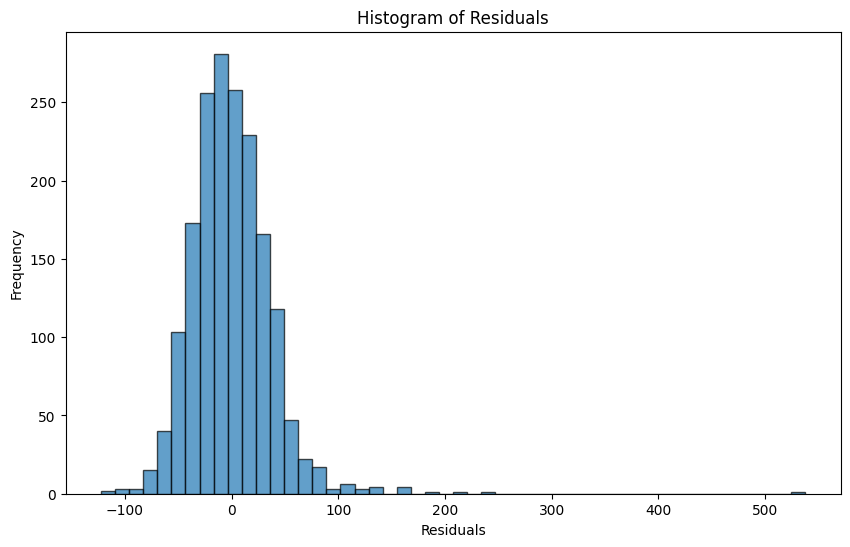

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

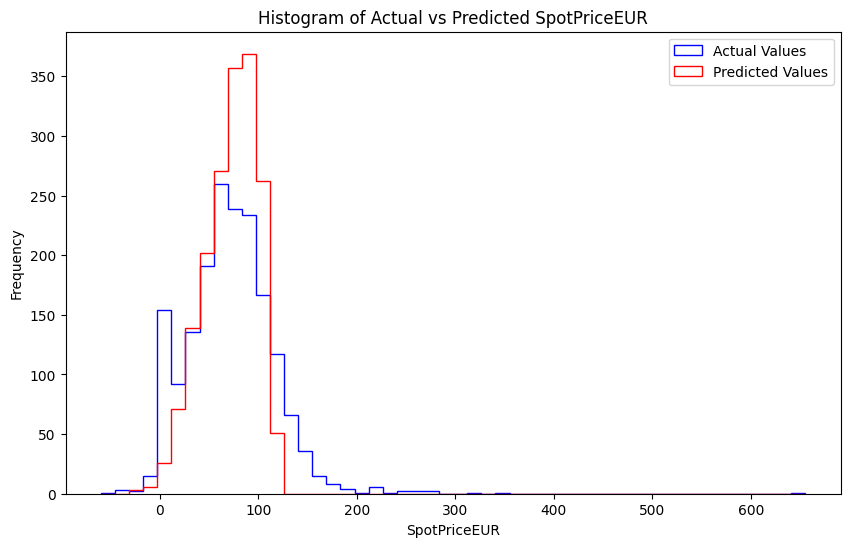

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=50, histtype='step', label='Actual Values', color='blue')
plt.hist(y_pred, bins=50, histtype='step', label='Predicted Values', color='red', range=(y_test.min(), y_test.max()))
plt.xlabel('SpotPriceEUR')
plt.ylabel('Frequency')
plt.title('Histogram of Actual vs Predicted SpotPriceEUR')
plt.legend()
plt.show()

In [35]:
# Find the indices of the residuals
residual_indices = residuals.index

# Select the corresponding rows in mergeddf
residuals_df = mergeddf.loc[residual_indices].copy()

# Add the residuals to the new dataframe
residuals_df['residuals'] = residuals

# Calculate the Pearson correlation between residuals and all other variables in the new dataframe
correlation_matrix = residuals_df.corr()
residual_correlations = correlation_matrix['residuals'].sort_values(ascending=False)

print(residual_correlations)

residuals                                       1.000000
SpotPriceEUR                                    0.811168
SpotPriceDKK                                    0.811142
is_day ()                                       0.171552
pressure_msl (hPa)                              0.156928
surface_pressure (hPa)                          0.156783
snow_depth (m)                                  0.099132
HourUTC                                         0.080400
HourDK                                          0.080384
time                                            0.080384
sunshine_duration (s)                           0.074567
cloud_cover_low (%)                             0.069243
snowfall (cm)                                   0.061868
wind_direction_100m (°)                         0.059920
wind_direction_10m (°)                          0.051659
wind_speed_10m (km/h)                           0.037709
wind_gusts_10m (km/h)                           0.031600
diffuse_radiation (W/m²)       

# add ShareMWh and hour of day to the model

In [ ]:
# Select the input variables and the target variable
X_ext = mergeddf[['wind_speed_10m (km/h)', 'terrestrial_radiation (W/m²)', 'ShareMWh', 'hour_of_day']]
y = mergeddf['SpotPriceEUR']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ext, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model_ext = LinearRegression()
model_ext.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ext = model_ext.predict(X_test)

# Evaluate the model
mse_ext = mean_squared_error(y_test, y_pred_ext)
r2_ext = r2_score(y_test, y_pred_ext)

print(f"Mean Squared Error: {mse_ext}")
print(f"R^2 Score: {r2_ext}")

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, model_ext.coef_):
    print(f"{feature}: {coef}")

Mean Squared Error: 1558.7852334148647
R^2 Score: 0.31793027076967884
Model Coefficients:
wind_speed_10m (km/h): -3.2472923198841657
terrestrial_radiation (W/m²): -0.04659459974994194
ShareMWh: 0.003564849042076002
hour_of_day: 1.4276488123724251


In [ ]:
# Calculate baseline MSE (predicting the mean of the target variable)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mse = mean_squared_error(y_test, baseline_pred)
print(f"Baseline Mean Squared Error: {baseline_mse}")

# Compare model MSE with baseline MSE
improvement = (baseline_mse - mse_ext) / baseline_mse * 100
print(f"Improvement over baseline: {improvement:.2f}%")

Baseline Mean Squared Error: 2286.951490738339
Improvement over baseline: 31.84%


MSE increased, but R2 ever so slightly higher, but still terrible

Multicollinearity:

If the new variables are highly correlated with existing ones, it can make the model unstable, especially in linear models. 
This instability might increase the MSE, particularly on test data.
